# 2D Face Alignment using CNN on AFLW2000

## Motivation

[AFLW2000-3D](http://www.cbsr.ia.ac.cn/users/xiangyuzhu/projects/3DDFA/main.htm) is a dataset of 2000 images that have been annotated with image-level 68-point 3D facial landmarks. This dataset is typically used for evaluation of 3D facial landmark detection models.
It contains diverse head poses and can be used to guess invinsible landmarks in 3D space. 

However, we will use it in order to train a model that will be able to detect 2D facial landmarks. Indeed, this dataset is relatively light and contains a great variety of face images. Moreover, it can be downloaded using TensorFlow's [TFDS](https://www.tensorflow.org/datasets) within this notebook.

The goal isn't to build the best landmark detector in terms of robustness and precision, but to show how we can provide decent results with a small amount of data and not much training ressources. Indeed, this whole notebook can be executed within a few minutes in a Google Colab environment !

## Getting started

In [ ]:
!pip install -q tfds-nightly

     |████████████████████████████████| 3.8MB 8.4MB/s 


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds 
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2

In [ ]:
# Check TF version & make sure it is running on GPU
print(tf.__version__)
print(tf.test.gpu_device_name())

2.4.1
/device:GPU:0


## Load Dataset

TFDS can load and split the dataset in one line. Since 2000 images is a relatively small amount of sample considering the task, we will use 95% of the samples for training and only 5% for evaluation.

Moreover, TFDS will store and display some useful information about the dataset (eg. inputs size & types).

Each sample consists of :
- a *450x450* RGB image (uint8, unnormalized).
- 68 *(x,y)* landmarks coordinates (float32, normalized).
- 68 *z* coordinates corresponding to the depth of the previous landmarks. Focusing on 2D detection, we won't consider them at the moment.

In [ ]:
!tfds build --register_checksums
ds, info = tfds.load('aflw2k3d', with_info = True, split=['train[:95%]', 'train[95%:]'])
info

tfds.core.DatasetInfo(
    name='aflw2k3d',
    full_name='aflw2k3d/1.0.0',
    description="""
    AFLW2000-3D is a dataset of 2000 images that have been annotated with image-level
    68-point 3D facial landmarks.
    This dataset is typically used for evaluation of 3D facial landmark detection
    models. The head poses are very diverse and often hard to be detected by a 
    cnn-based face detector.
    The 2D landmarks are skipped in this dataset, since some of the data are not
    consistent to 21 points, as the original paper mentioned.
    """,
    homepage='http://www.cbsr.ia.ac.cn/users/xiangyuzhu/projects/3DDFA/main.htm',
    data_path='/root/tensorflow_datasets/aflw2k3d/1.0.0',
    download_size=83.36 MiB,
    dataset_size=42.48 MiB,
    features=FeaturesDict({
        'image': Image(shape=(450, 450, 3), dtype=tf.uint8),
        'landmarks_68_3d_xy_normalized': Tensor(shape=(68, 2), dtype=tf.float32),
        'landmarks_68_3d_z': Tensor(shape=(68, 1), dtype=tf.float32),
   

In [ ]:
ds_train = ds[0] # 95% (1900 images)
ds_test = ds[1] # 5% (100 images)

Let's have a look on some of the loaded samples !

,image,landmarks_68_3d_xy_normalized,landmarks_68_3d_z
0,,"ndarray(shape=(68, 2), dtype=float32)","ndarray(shape=(68, 1), dtype=float32)"
1,,"ndarray(shape=(68, 2), dtype=float32)","ndarray(shape=(68, 1), dtype=float32)"
2,,"ndarray(shape=(68, 2), dtype=float32)","ndarray(shape=(68, 1), dtype=float32)"
3,,"ndarray(shape=(68, 2), dtype=float32)","ndarray(shape=(68, 1), dtype=float32)"
4,,"ndarray(shape=(68, 2), dtype=float32)","ndarray(shape=(68, 1), dtype=float32)"

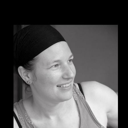
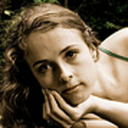
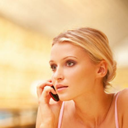
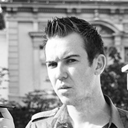
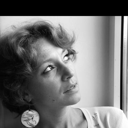

In [ ]:
tfds.as_dataframe(ds_train.take(5), info)

As we can see, AFLW2000 offers a wide variety in terms of face pose, colors, backgrounds, facial expressions... If training goes well, the model should be applicable to any kind of face image.

In [ ]:
ds_train

<PrefetchDataset shapes: {image: (450, 450, 3), landmarks_68_3d_xy_normalized: (68, 2), landmarks_68_3d_z: (68, 1)}, types: {image: tf.uint8, landmarks_68_3d_xy_normalized: tf.float32, landmarks_68_3d_z: tf.float32}>

## Prepare Dataset 

In order to make trainig easier, we will have to tweak the dataset.

- At this point, TFDS loaded an instance of ```PrefetchDataset```which is a pretty [undocumented class](https://www.tensorflow.org/api_docs/python/tf/raw_ops/PrefetchDataset). That's why we will convert it as a regular tf.data.Dataset.
- In order to make training faster and more RAM-friendly, images will be resized to 128x128, which doesn't seem to impact too much the quality of the model.
- A (136,) Tensor containing the landmarks coordinates (68*(x,y) components) will be formed instead of the (68,2) Tensor. It will fit the output of our network.

In [ ]:
def prepare_dataset(ds):
    
  # experimental trick for conversion
    ds = list(ds)
    images = []
    landmarks = []
    for sample in ds :
        images.append(sample["image"])
        landmarks.append(sample["landmarks_68_3d_xy_normalized"])
    
    # resizing images
    images = tf.image.resize(images, (128,128))
    
    # conversion to np-arrays that can be used to form TF-friendly datasets
    images = np.array(images)
    landmarks = np.array(landmarks)
    landmarks = np.reshape(landmarks, (landmarks.shape[0], 68*2))
    
    # returning a supervised dataset (image -> landmarks)
    return tf.data.Dataset.from_tensor_slices((images, landmarks))

ds_train = prepare_dataset(ds_train)
ds_test = prepare_dataset(ds_test)
ds_train

<TensorSliceDataset shapes: ((128, 128, 3), (136,)), types: (tf.float32, tf.float32)>

## Setting up a data Pipeline

- Images will be normalized using a mapping.
- Cache for performance.
- Shuffle for randomness.
- Batch in order to get unique batches at each epoch.
- Prefetch for performance.

Refers to the [tf.data performance guide](https://www.tensorflow.org/guide/data_performance?hl=en#prefetching) to build an efficient pipeline !

### Training pipeline

In [ ]:
def normalize_image(image, landmarks):
    return tf.cast(image, tf.float32) / 255., landmarks

ds_train = ds_train.map(normalize_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(1900)
ds_train = ds_train.batch(16)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

### Evaluation Pipeline

In [ ]:
ds_test = ds_test.map(normalize_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(16)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

## Define the Model

The CNN model is the one provided by Yin Guobing in his [cnn-facial-landmarks](https://github.com/yinguobing/cnn-facial-landmark) repository, which is a nice introduction to facial landmarks learning.

In [ ]:
class CNN_model(keras.Model):
    def __init__(self, output_size):
        
        super(CNN_model, self).__init__(output_size)
        self.os = output_size
        
        # Convolutional layers.
        self.conv_1 = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu') 
        self.conv_2 = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu')
        self.conv_3 = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu')
        self.conv_4 = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu')
        self.conv_5 = keras.layers.Conv2D(filters=64, kernel_size=[3, 3], strides=(1, 1), padding='valid', activation='relu')
        self.conv_6 = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu')
        self.conv_7 = keras.layers.Conv2D(filters=128, kernel_size=[3, 3], strides=(1, 1), padding='valid', activation='relu')
        self.conv_8 = keras.layers.Conv2D(filters=256, kernel_size=[3, 3], strides=(1, 1), padding='valid', activation='relu')
        
        # Pooling layers.
        self.pool_1 = keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid')
        self.pool_2 = keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid')
        self.pool_3 = keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid')
        self.pool_4 = keras.layers.MaxPool2D(pool_size=[2, 2], strides=(1, 1), padding='valid')
        
        # Dense layers.
        self.dense_1 = keras.layers.Dense(units=1024, activation='relu', use_bias=True)
        self.dense_2 = keras.layers.Dense(units=self.os , activation='linear', use_bias=True)
        
        # Batch norm layers.
        self.bn_1 = keras.layers.BatchNormalization()
        self.bn_2 = keras.layers.BatchNormalization()
        self.bn_3 = keras.layers.BatchNormalization()
        self.bn_4 = keras.layers.BatchNormalization()
        self.bn_5 = keras.layers.BatchNormalization()
        self.bn_6 = keras.layers.BatchNormalization()
        self.bn_7 = keras.layers.BatchNormalization()
        self.bn_8 = keras.layers.BatchNormalization()
        self.bn_9 = keras.layers.BatchNormalization()

        # Flatten layers.
        self.flatten_1 = keras.layers.Flatten()
        
    
    # Define forward propagation.
    def call(self, inputs):
        
        # === Input Layer ===
        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = self.pool_1(x)
        
        # === Layer 2 ===
        x = self.conv_2(x)
        x = self.bn_2(x)
        x = self.conv_3(x)
        x = self.bn_3(x)
        x = self.pool_2(x)
        
        # === Layer 3 ===
        x = self.conv_4(x)
        x = self.bn_4(x)
        x = self.conv_5(x)
        x = self.bn_5(x)
        x = self.pool_3(x)
        
        # === Layer 4 ===
        x = self.conv_6(x)
        x = self.bn_6(x)
        x = self.conv_7(x)
        x = self.bn_7(x)
        x = self.pool_4(x)
        
        # === Layer 5 ===
        x = self.conv_8(x)
        x = self.bn_8(x)
        
        # === Layer 6 ===
        x = self.flatten_1(x)
        x = self.dense_1(x)
        x = self.bn_9(x)
        
        return self.dense_2(x)
        
# Let's create an instance of the model.
# 68 landmarks -> the number of outputs is 68*2 = 136 for 2D coordinates.
nb_outputs = 68*2
model = CNN_model(nb_outputs)

## Training

First of all, we need to define an optimizer and a loss function. Since the problem here is a **regression task**, we will use the Mean Square Error (MSE).

In [ ]:
optimizer = keras.optimizers.Adam(0.01)
metrics = [tf.keras.metrics.MeanSquaredError()] 
loss_object = keras.losses.mean_squared_error

model.compile(optimizer, loss_object, metrics)

Let's evaluate the model by learning a few epochs :

In [ ]:
history = model.fit(ds_train, epochs=10, validation_data=ds_test)

Epoch 1/10
119/119 [==============================] - 4s 22ms/step - loss: 0.8071 - mean_squared_error: 0.8071 - val_loss: 0.2182 - val_mean_squared_error: 0.2182
Epoch 2/10
119/119 [==============================] - 2s 20ms/step - loss: 0.0275 - mean_squared_error: 0.0275 - val_loss: 0.0306 - val_mean_squared_error: 0.0306
Epoch 3/10
119/119 [==============================] - 2s 20ms/step - loss: 0.0230 - mean_squared_error: 0.0230 - val_loss: 0.0186 - val_mean_squared_error: 0.0186
Epoch 4/10
119/119 [==============================] - 2s 20ms/step - loss: 0.0197 - mean_squared_error: 0.0197 - val_loss: 0.0148 - val_mean_squared_error: 0.0148
Epoch 5/10
119/119 [==============================] - 2s 20ms/step - loss: 0.0151 - mean_squared_error: 0.0151 - val_loss: 0.0141 - val_mean_squared_error: 0.0141
Epoch 6/10
119/119 [==============================] - 2s 20ms/step - loss: 0.0139 - mean_squared_error: 0.0139 - val_loss: 0.0136 - val_mean_squared_error: 0.0136
Epoch 7/10
119/119 [==

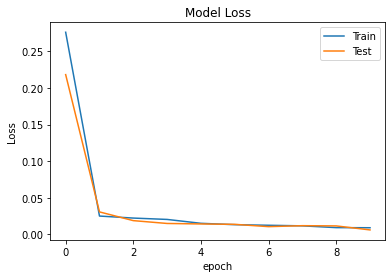

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

We can see that the loss decreases over epochs and there is no evidence of overfitting. However, there is a huge loss gap between the first and the second epoch, we should plot the loss function from this one.

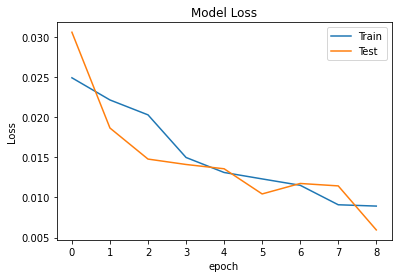

In [ ]:
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()


Again, loss is on a decreasing trend, and the model seems to generalize well new data.

Let's keep training the model !

In [ ]:
history = model.fit(ds_train, epochs=50, validation_data=ds_test)
optimizer.lr.assign(0.001)
history = model.fit(ds_train, epochs=10, validation_data=ds_test)
optimizer.lr.assign(0.0001)
history = model.fit(ds_train, epochs=10, validation_data=ds_test)

Epoch 1/50
119/119 [==============================] - 2s 21ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 0.0075 - val_mean_squared_error: 0.0075
Epoch 2/50
119/119 [==============================] - 2s 20ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 3/50
119/119 [==============================] - 2s 20ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0053 - val_mean_squared_error: 0.0053
Epoch 4/50
119/119 [==============================] - 2s 20ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0090 - val_mean_squared_error: 0.0090
Epoch 5/50
119/119 [==============================] - 2s 21ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 6/50
119/119 [==============================] - 2s 20ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0056 - val_mean_squared_error: 0.0056
Epoch 7/50
119/119 [==

## Test the trained model

Now that the model seems pretty strong, let's try it on a new image !

In [ ]:
def detector(source):
  # load the image
  img = cv2.imread(source)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # resize & normalize
  img_n = cv2.resize(img, (128, 128))
  img_n = (img_n/255.).astype('float32')

  # expand dim in order to give it to the model
  img_n = np.expand_dims(img_n, axis=0)

  # predict & get landmarks coordinates ready for plotting
  prediction = model.predict(img_n)[0,:]
  l_x = []
  l_y = []
  for i in range(prediction.shape[0]):
    if (i%2 == 0):
      l_x.append(prediction[i])
    else:
      l_y.append(prediction[i])
  l_x = np.array(l_x)
  l_y = np.array(l_y)

  # plot the result !
  plt.figure(figsize=(5,5))
  plt.imshow(img)
  plt.scatter(l_x*img.shape[0], l_y*img.shape[1], s=3)
  plt.axis('square')
  plt.xlim(0,img.shape[0])
  plt.ylim(0,img.shape[1])
  plt.gca().invert_yaxis()
  plt.show()

  return prediction

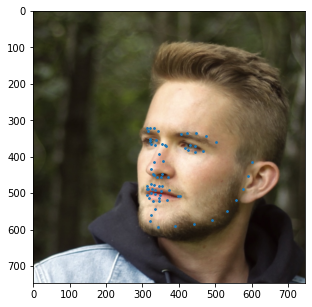

In [ ]:
pred = detector("leo.jpg")

As we can see, the result is quite satisfactory considering the dataset size and the training time. We can see that the model attempts to predict 'invinsible' landmarks hidden because of the face's angle. We can thus guess that the result would have felt more natural if we'd have learnt the $z$ coordinate of each landmark in order to get their depth information.